# How to compute $\alpha$ and $\beta$ for a given asset
By Evgenia "Jenny" Nitishinskaya and Delaney Granizo-Mackenzie

Notebook released under the Creative Commons Attribution 4.0 License.

---

A fundamental concept in portfolio management and risk allocation is computing the $\beta$ of an asset. $\beta$ is a measurement of the covariance of the asset with the market in general, and is expressed in this model.

$$r_a \approx \alpha + \beta r_b$$

$r_a$ are the returns of the asset, and $r_b$ are the returns of the benchmark, usually a proxy for the market like the S&P 500.

$\beta$ can be defined as

$$\beta = \frac{Cov(r_a, r_b)}{Var(r_b)}$$

To actually compute $\beta$, we can use linear regression. We find the OLS best fit line for all points $(r_{a, t}, r_{b, t})$, where $r_{a, t}$ is the asset's returns for time $t$, and $r_{b, t}$ the same for the benchmark. The slope of this line is $\beta$, and the y-intercept is $\alpha$.

We'll start by getting data for a specific time range.

In [2]:
# Import libraries
import numpy as np
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

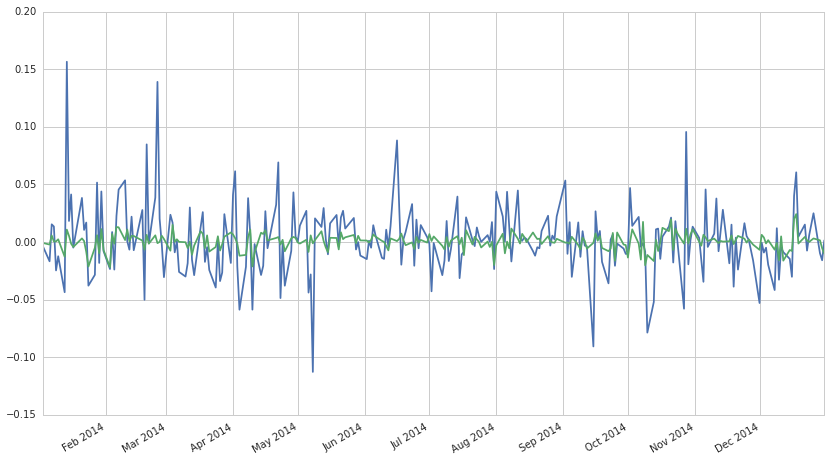

In [3]:
# Get data for the specified period and stocks
start = '2014-01-01'
end = '2015-01-01'
asset = get_pricing('TSLA', fields='price', start_date=start, end_date=end)
benchmark = get_pricing('SPY', fields='price', start_date=start, end_date=end)

# We have to take the percent changes to get to returns
# Get rid of the first (0th) element because it is NAN
r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]

# Let's plot them just for fun
r_a.plot()
r_b.plot();

Now we have to fit a line to the data to determine the slope. We use Ordinary Least Squares (OLS) for this.

In [4]:
# Let's define everything in familiar regression terms
X = r_b.values # Get just the values, ignore the timestamps
Y = r_a.values

# We add a constant so that we can also fit an intercept (alpha) to the model
# This just adds a column of 1s to our data
X = sm.add_constant(X)
model = regression.linear_model.OLS(Y, X)
model = model.fit()
# Remove the constant now that we're done
X = X[:, 1]
alpha = model.params[0]
beta = model.params[1]
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)

alpha: 0.00108062811902
beta: 1.92705010047


We can plot the line of best fit to visualize this.

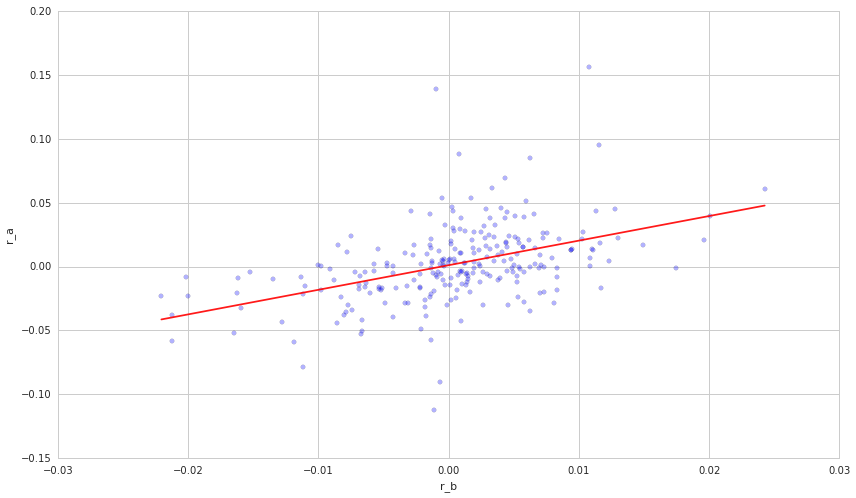

In [5]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha

plt.scatter(X, Y, alpha=0.3) # Plot the raw data
plt.xlabel("r_b")
plt.ylabel("r_a")

# Add the regression line, colored in red
plt.plot(X2, Y_hat, 'r', alpha=0.9);

# How to compute the volatility for a given asset

The volatility $\sigma$ of an asset is the standard deviation of its returns. A low volatility means that the returns are generally close to the mean, while a high volatility corresponds to returns that are often much higher and often much lower than expected.

We'll go ahead and continue using the stock from before:

In [5]:
# Use numpy to find the standard deviation of the returns
SD = np.std(Y)
print SD

# Let's compute the volatility for our benchmark, as well
benchSD = np.std(X)
print benchSD

0.0304267478169
0.00710144477583


This gives the daily volatility. As expected, the benchmark has a much lower volatility than the stock - a volatile asset would not make a good benchmark.

We generally compute the annualized volatility so that we can compare volatilities for daily, weekly, or monthly samples. To get it we normalize the standard deviation of the daily returns by multiplying by the square root of the number of trading days in a year:

$$\sigma_{\text{annual}} = SD \cdot \sqrt{252}$$

In [6]:
vol = SD*(252**.5)
print vol

benchvol = benchSD*(252**.5)
print benchvol

0.483009647568
0.112731940957


This tells us that we should expect the returns of a benchmark to cluster more closely around their mean than those of the stock. We can plot histograms of the returns to see this:

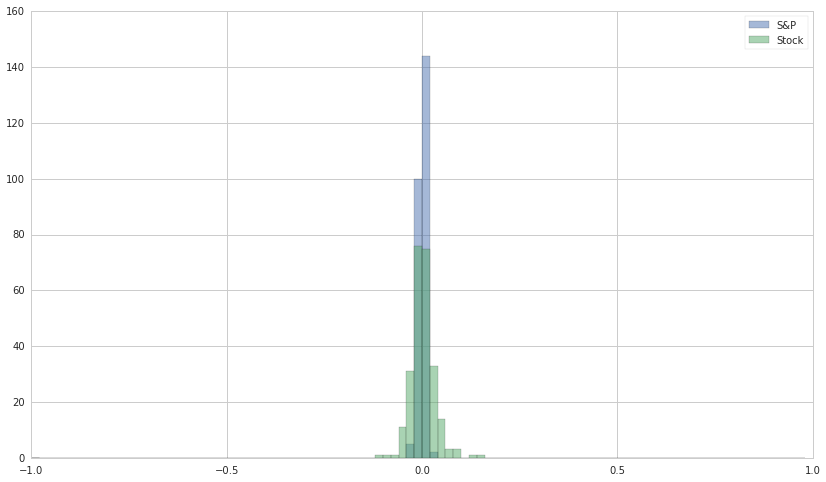

In [7]:
# Since we have many distinct values, we'll lump them into buckets of size .02
x_min = int(math.floor(X.min()))
x_max = int(math.ceil(X.max()))
plt.hist(X, bins=[0.02*i for i in range(x_min*50, x_max*50)], alpha=0.5, label='S&P')
plt.hist(Y, bins=[0.02*i for i in range(x_min*50, x_max*50)], alpha=0.5, label='Stock')
plt.legend(loc='upper right');

# How to compute the Sharpe and information ratios for an asset

The Sharpe and information ratios are used to calculate how well the historic returns of an asset compensate for its risk, relative to some benchmark or risk-free asset. An asset with a higher ratio has either higher returns, lower risk, or both. As when computing volatility, the standard deviation of the returns is used to measure risk.

$$R = \frac{E[r_a - r_b]}{\sqrt{Var(r_a - r_b)}}$$

$r_a$ are the returns of the asset, and $r_b$ are the returns of the benchmark; generally, Treasury bills are used when computing the Sharpe ratio, while the S&P 500 index is commonly used for the information ratio. We subtract the returns of the benchmark from the returns of the asset becasue we would like to get higher returns through our investment than we would, say, simply buying Treasury bills.

In [8]:
# Get the returns for a treasury-tracking ETF to be used in the Sharpe ratio
# Note that BIL is only being used in place of risk free rate,
# and should not be used in such a fashion for strategy development
riskfree = get_pricing('BIL', fields='price', start_date=start, end_date=end)
r_b_S = riskfree.pct_change()[1:]
X_S = r_b_S.values

# Compute the Sharpe ratio for the asset we've been working with
SR = np.mean(Y - X_S)/np.std(Y - X_S)

# Compute the information ratio for the asset we've been working with, using the S&P index
IR = np.mean(Y - X)/np.std(Y - X)

# Print results
print 'Sharpe ratio: ' + str(SR)
print 'Information ratio: ' + str(IR)

Sharpe ratio: 0.0665469573483
Information ratio: 0.0548536005258


# How to compute the Sortino ratio for an asset

The Sharpe and information ratios are useful, but they penalize stocks for going above the expected return as well as for going below it. The Sortino ratio is modified to take into account only returns that fall below the mean.

$$S = \frac{E[r_a - r_b]}{\sqrt{Semivar(r_a - r_b)}}$$

The semivariance is the variance below the mean, and so quantifies the downside risk of our asset. Here as in the Sharpe ratio returns on Treasury bills can be used for $r_b$. The more skewed the distribution of returns is, the more the Sortino ratio will differ from the Sharpe ratio.

In [11]:
# To compute the semideviation, we want to filter out values which fall above the mean
meandif = np.mean(Y - X_S)
lows = [e for e in Y - X_S if e <= meandif]

# Because there is no built-in semideviation, we'll compute it ourselves
def dist(x):
    return (x - meandif)**2
semidev = math.sqrt(sum(map(dist,lows))/len(lows))

Sortino = meandif/semidev
print 'Sortino ratio: ' + str(Sortino)

Sortino ratio: 0.0738307139237
